## Import Packages

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Parameter Settings

In [2]:
region = [(0,1), (.45,.6), (.55,.6), (1,1)]
blur_kernel_size = 5
canny_thres = (70, 200)
hough_params = (1, math.pi/180, 40)
grouping_thres = (30, 0.2)
group_size_thres = 2

## Helper Functions

In [3]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, normal_vertices):
    vertices = [(int(v[0]*img.shape[1]), int(v[1]*img.shape[0])) for v in normal_vertices]
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, np.array([vertices]), ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        x1,y1,x2,y2 = line
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold):
    lines = cv2.HoughLines(img, rho, theta, threshold)
    return lines.squeeze()

def are_colinear(rho1, theta1, rho2, theta2, rho_thres, theta_thres):
    drho = abs(rho2-rho1)
    dtheta = abs(theta2-theta1)
    return drho < rho_thres and dtheta < theta_thres

def group_lines(lines, rho_thres, theta_thres):
    lines.sort(key=(lambda x: x[1]))
    groups = []
    for index, line in enumerate(lines):
        if (index > 0 and are_colinear(line[0], line[1], lines[index-1][0], lines[index-1][1], rho_thres, theta_thres)):
            groups[-1].append(line)
        else:
            groups.append([line])
    return groups

def average_lines(lines):
    return [
        sum([line[0] for line in lines])/len(lines),
        sum([line[1] for line in lines])/len(lines)
    ]

def polar_to_cartesian_line(rho, theta):
    return (-math.cos(theta)/math.sin(theta), rho/math.sin(theta))

## Test Images

In [4]:
import os
os.listdir("test_images/")

['challenge1.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline

### 1. Load Image

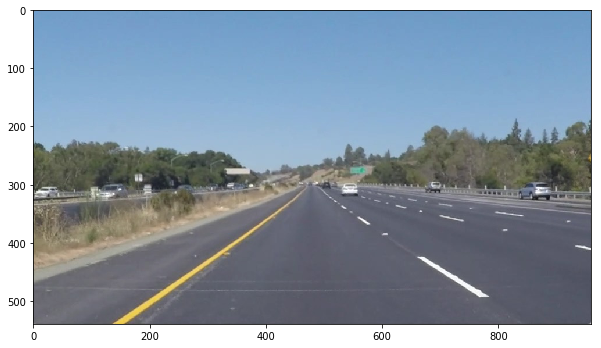

In [5]:
img = plt.imread('test_images/solidYellowLeft.jpg')
plt.imshow(img)

### 2. Convert to Grayscale & Blur

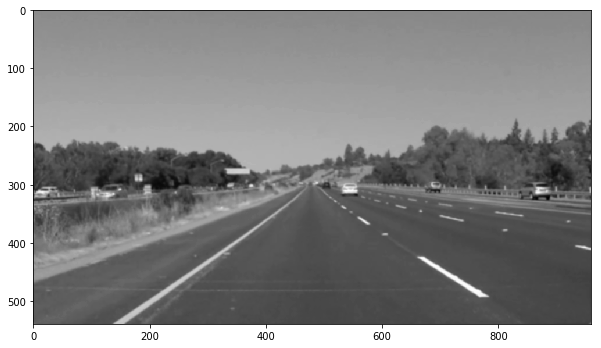

In [6]:
gray_img = grayscale(img)
blur_img = gaussian_blur(gray_img, blur_kernel_size)
plt.imshow(blur_img, cmap='gray')

### 3. Find Edges & Select Region

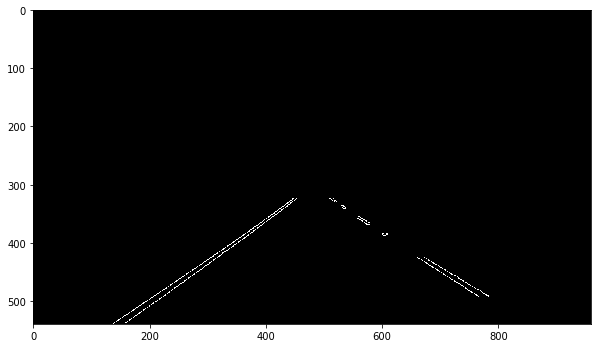

In [7]:
edges_img = canny(blur_img, canny_thres[0], canny_thres[1])
edges_img = region_of_interest(edges_img, region)
plt.imshow(edges_img, cmap='gray')

### 4. Detect Lines

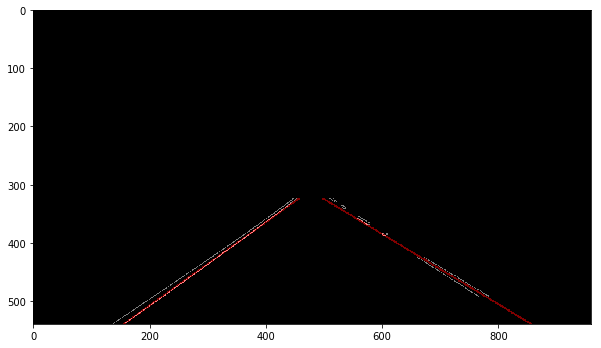

In [8]:
hlines = hough_lines(edges_img, hough_params[0], hough_params[1], hough_params[2]).tolist()
groups = group_lines(hlines, grouping_thres[0], grouping_thres[1])
groups = [group for group in groups if len(group) >= group_size_thres]
hlines = [average_lines(group) for group in groups]
hlines = [polar_to_cartesian_line(rho, theta) for rho, theta in hlines if abs(theta) > .1]

lines = [(0, int(b), img.shape[1], int(m*img.shape[1]+b)) for m, b in hlines]
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
draw_lines(line_img, lines)
line_img = region_of_interest(line_img, region)
line_img = cv2.addWeighted(cv2.cvtColor(edges_img, cv2.COLOR_GRAY2RGB), .5, line_img, .5, 0)
plt.imshow(line_img)

### 5. Identify Lanes

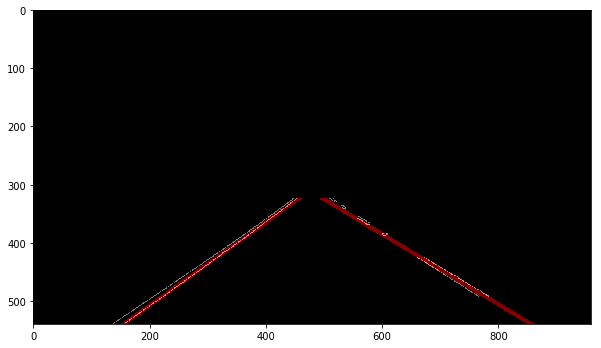

In [9]:
hlines.sort(key=(lambda x: x[0]))
lines = [(0, int(b), img.shape[1], int(m*img.shape[1]+b)) for m, b in hlines]
left_lane = lines[-1]
right_lane = lines[0]

line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
draw_lines(line_img, [left_lane, right_lane], thickness=5)
line_img = region_of_interest(line_img, region)
line_img = cv2.addWeighted(cv2.cvtColor(edges_img, cv2.COLOR_GRAY2RGB), .5, line_img, .5, 0)
plt.imshow(line_img)

## Test on Videos

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(img):
    # gray & blur
    gray_img = grayscale(img)
    blur_img = gaussian_blur(gray_img, blur_kernel_size)
    
    # find edges & select region
    edges_img = canny(blur_img, canny_thres[0], canny_thres[1])
    edges_img = region_of_interest(edges_img, region)

    # detect lines
    hlines = hough_lines(edges_img, hough_params[0], hough_params[1], hough_params[2]).tolist()
    groups = group_lines(hlines, grouping_thres[0], grouping_thres[1])
    groups = [group for group in groups if len(group) >= group_size_thres]
    hlines = [average_lines(group) for group in groups]
    hlines = [polar_to_cartesian_line(rho, theta) for rho, theta in hlines if abs(theta) > .1]

    # identify lanes
    hlines.sort(key=(lambda x: x[0]))
    lines = [(0, int(b), img.shape[1], int(m*img.shape[1]+b)) for m, b in hlines]
    left_lane = lines[-1]
    right_lane = lines[0]

    # draw lanes
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, [left_lane, right_lane], thickness=5)
    line_img = region_of_interest(line_img, region)
    line_img = cv2.addWeighted(img, .6, line_img, .4, 0)
    return line_img

Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:12<00:00, 18.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 14.4 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:40<00:00, 16.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 42 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [16]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:30<00:00,  8.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 33.1 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))